<table style="background-color: transparent; border: none;">   
  <tr>  
    <td>
    <br/>   
    <img src="https://cdn.prod.website-files.com/6606dc3fd5f6645318003df4/6678476dc198b5a75b8c8873_ES_Logo_Black_5.png" width="75" alt="img"/>
    <br/>
    </td>     
    <td><h1>Project Research&nbsp&nbsp&nbsp</h1></td>   
    
  </tr>
</table>

</br>

> __Author:__ Grace Tang

> __Edited:__ `04.22.25`

---
<br/>

#### __Description__

Predicting the functions of proteins is an essential problem in the study of proteins. Many previous works developed computational methods that utilize protein sequence information to predict protein functions. With the advancement of `AlphaFold2`, accurate protein structure data has been available for hundreds of millions of proteins.

Incorporating structure information should be able to further boost the performance of protein function prediction methods. There are several potential ways to utilize the structure information: use computer-vision-like models to extract information from contact maps; use graph neural networks to encode 3D structures; use pretrained protein structure model (e.g., `ESM-IF`).

In addition, with the advancement of LLMs, the text annotations of proteins can also be leveraged as an extra information source for protein function prediction, e.g., use LLM as encoder to encode the text annotations of proteins. Utilizing the information from sequence, structure, and text annotations, we can develop a model that accurately predicts protein functions.

__Using a subset of the dataset used for [DeepFRI](https://github.com/flatironinstitute/DeepFRI) (a similar protein function prediction model) we aim to coallesce sequence data and structure data to predict protein function in the form of [EC Numbers](https://en.wikipedia.org/wiki/Enzyme_Commission_number).__

[[1]](ttps://www.biorxiv.org/content/10.1101/2022.11.29.518451v1), [[2]](https://www.nature.com/articles/s42003-024-07359-z), [[3]](https://www.nature.com/articles/s41467-021-23303-9), [[4]](https://www.biorxiv.org/content/10.1101/2024.05.14.594226v1 )


#### Methodology

> _This section relies on having_ `annotations.tsv`, `train.txt`, `validation.txt`, _and_ `sequences.fasta` _in your runtime_

We need a model that turns raw protein sequences into one or more EC numbers. Our goal is simplicity, speed, and the ability to predict multiple functions per protein.

__Embedding:__

We map each amino acid to a **128-dimensional vector** via a small, learnable embedding layer.  
  - Captures key sequence patterns  without the heavy storage or compute of large pre-trained models.  
  - Fits comfortably in GPU memory when training on ~15,000 proteins.

__Pooling:__

We apply **masked mean pooling** to average embeddings across the sequence.  
  - Converts variable-length sequences into fixed-size fingerprints.  
  - Ensures padding tokens do not skew the average, keeping representations true to the real residues.

__Model Architecture:__

A simple two-layer feedforward network with a 256-unit hidden layer and 50% dropout.  
  - Two layers os enough capacity to learn interactions between sequence features, but not so deep as to overfit.  
  - Dropout promotes generalization by preventing reliance on any single feature.

Each EC category is a separate output node with a sigmoid activation, trained using binary cross-entropy.  
  - Proteins can carry **multiple EC numbers**.  
  - Independent sigmoids allow the model to assign all applicable ECs without forcing a single choice.

__Training:__

- **Loss:** `BCEWithLogitsLoss` for multi-label classification  
- **Batch size:** `32`  
- **Optimizer:** `AdamW` (`lr=1e-3`, `weight_decay=1e-5`)  
- **Epochs:** `10` (monitor validation `F1` for early stopping)  

__Next Steps:__

- **Threshold Calibration:** Use validation data to pick optimal probability cutoffs for each EC.  
- **Feature Extensions:** Add graphical information from a contact map into the embedding __and__ pick a less expensive sequence embedding approach then `ESM` to do the sequence embeddings.


In [11]:
import os
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.nn.utils.rnn import pad_sequence

In [12]:
def parse_fasta(path):
    seqs = {}
    with open(path) as f:
        curr, lines = None, []
        for line in f:
            if line.startswith('>'):
                if curr:
                    seqs[curr] = ''.join(lines)
                curr = line[1:].split()[0]
                lines = []
            else:
                lines.append(line.strip())
        if curr:
            seqs[curr] = ''.join(lines)
    return seqs

def parse_annotations(path):
    ann_map, all_ec = {}, set()
    with open(path) as f:
        for ln in f:
            if ln.startswith('### PDB-chain'):
                break
        for ln in f:
            if not ln.strip() or ln.startswith('#'): continue
            pid, ecs = ln.strip().split('\t')
            ec_list = [e.strip() for e in ecs.split(',') if e.strip()]
            ann_map[pid] = ec_list
            all_ec.update(ec_list)
    classes = sorted(all_ec)
    return ann_map, classes

def build_df(ids, seqs, ann_map, classes):
    rows = []
    for pid in ids:
        seq = seqs.get(pid, '')
        if not seq:
            print(f"Warning: {pid} not found")
            continue
        labels = [1 if ec in ann_map.get(pid, []) else 0 for ec in classes]
        rows.append({'id': pid, 'sequence': seq, 'labels': labels})
    return pd.DataFrame(rows)

In [13]:
from google.colab import files
uploaded = files.upload()


Saving annotations.tsv to annotations (2).tsv
Saving sequences.fasta to sequences (2).fasta
Saving train.txt to train (2).txt
Saving validation.txt to validation (2).txt


In [14]:
train_ids = [l.strip() for l in open('train.txt') if l.strip()]
val_ids   = [l.strip() for l in open('validation.txt') if l.strip()]

In [15]:
db_seqs = parse_fasta('sequences.fasta')
ann_map, classes = parse_annotations('annotations.tsv')

In [16]:
df_train = build_df(train_ids, db_seqs, ann_map, classes)
df_val   = build_df(val_ids,   db_seqs, ann_map, classes)

In [17]:
aa_list = list("ACDEFGHIKLMNPQRSTVWY")
aa2idx = {aa: i+1 for i, aa in enumerate(aa_list)}
pad_idx = 0
unk_idx = len(aa_list) + 1

def seq_to_indices(seq):
    return [aa2idx.get(res, unk_idx) for res in seq]

class ProteinDataset(Dataset):
    def __init__(self, df):
        self.seqs = [seq_to_indices(s) for s in df['sequence']]
        self.labels = torch.tensor(df['labels'].tolist(), dtype=torch.float32)
    def __len__(self): return len(self.seqs)
    def __getitem__(self, idx):
        return torch.tensor(self.seqs[idx], dtype=torch.long), self.labels[idx]

In [18]:
def collate_fn(batch):
    seqs, labs = zip(*batch)
    padded = pad_sequence(seqs, batch_first=True, padding_value=pad_idx)
    return padded, torch.stack(labs)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
train_ds = ProteinDataset(df_train)
val_ds   = ProteinDataset(df_val)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, collate_fn=collate_fn)

In [19]:
class ECModel(nn.Module):
    def __init__(self, num_tokens, embed_dim, num_classes):
        super().__init__()
        self.embed = nn.Embedding(num_tokens+1, embed_dim, padding_idx=pad_idx)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x: [B, L]
        mask = (x != pad_idx).float()
        emb = self.embed(x)                # [B, L, E]
        summed = (emb * mask.unsqueeze(-1)).sum(1)
        lens = mask.sum(1, keepdim=True)
        pooled = summed / lens             # [B, E]
        return self.classifier(pooled)

In [20]:
model = ECModel(num_tokens=unk_idx, embed_dim=128, num_classes=len(classes)).to(device)
opt = optim.AdamW(model.parameters(), lr=1e-3)
crit = nn.BCEWithLogitsLoss()

In [21]:
epochs = 10
for ep in range(1, epochs+1):
    model.train(); total_loss = 0
    for seqs, labs in train_loader:
        seqs, labs = seqs.to(device), labs.to(device)
        logits = model(seqs)
        loss = crit(logits, labs)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item() * seqs.size(0)
    print(f"Epoch {ep} Train Loss: {total_loss/len(train_ds):.4f}")

    model.eval(); preds, targs = [], []
    with torch.no_grad():
        for seqs, labs in val_loader:
            seqs = seqs.to(device)
            logit = model(seqs)
            prob = torch.sigmoid(logit).cpu()
            preds.append(prob);
            targs.append(labs)
    preds = torch.vstack(preds).numpy() > 0.5
    targs = torch.vstack(targs).numpy() > 0.5
    print(
        "Val P, R, F1=",
        precision_score(targs, preds, average='micro', zero_division=0),
        recall_score(targs, preds, average='micro', zero_division=0),
        f1_score(targs, preds, average='micro', zero_division=0)
    )

Epoch 1 Train Loss: 0.0392
Val P, R, F1= 0.0 0.0 0.0
Epoch 2 Train Loss: 0.0178
Val P, R, F1= 0.6111111111111112 0.0037187288708586883 0.00739247311827957
Epoch 3 Train Loss: 0.0172
Val P, R, F1= 0.5757575757575758 0.006423258958755916 0.012704781009695755
Epoch 4 Train Loss: 0.0168
Val P, R, F1= 0.5 0.005409060175794456 0.010702341137123745
Epoch 5 Train Loss: 0.0164
Val P, R, F1= 0.625 0.010141987829614604 0.01996007984031936
Epoch 6 Train Loss: 0.0161
Val P, R, F1= 0.6052631578947368 0.00777552400270453 0.015353805073431242
Epoch 7 Train Loss: 0.0158
Val P, R, F1= 0.717391304347826 0.011156186612576065 0.021970705725699067
Epoch 8 Train Loss: 0.0155
Val P, R, F1= 0.6417910447761194 0.0145368492224476 0.028429752066115702
Epoch 9 Train Loss: 0.0153
Val P, R, F1= 0.6973684210526315 0.017917511832319134 0.03493737640079104
Epoch 10 Train Loss: 0.0150
Val P, R, F1= 0.7164179104477612 0.016227180527383367 0.031735537190082645


In [22]:
model.eval()
all_true, all_pred = [], []
with torch.no_grad():
    for seqs, labs in val_loader:
        seqs = seqs.to(device)
        logits = model(seqs)
        probs  = torch.sigmoid(logits).cpu()
        all_true.append(labs)
        all_pred.append((probs > 0.5).int())

true = torch.cat(all_true, dim=0)
pred = torch.cat(all_pred, dim=0)

rows = []
for pid, trow, prow in zip(val_ids, true, pred):
    true_ecs = [c for c, flag in zip(classes, trow) if flag]
    pred_ecs = [c for c, flag in zip(classes, prow) if flag]
    rows.append({
        'strain': pid,
        'validation EC class': ';'.join(true_ecs) or '-',
        'predicted': ';'.join(pred_ecs) or '-'
    })

results_df = pd.DataFrame(rows, columns=['strain', 'validation EC class', 'predicted'])
print(results_df)

        strain validation EC class predicted
0       1EF9-A             4.1.1.-         -
1       4BYF-A             3.6.4.-         -
2       1MVP-A            3.4.23.-         -
3       2BIH-A             1.7.1.-         -
4     6UE0-AAA     4.3.3.-;4.3.3.7         -
...        ...                 ...       ...
1724    2F9R-A             4.6.1.-         -
1725    1QQW-A   1.11.1.-;1.11.1.6         -
1726    6AHR-E   3.1.26.-;3.1.26.5         -
1727    2BJI-A    3.1.3.-;3.1.3.25         -
1728    3BAL-A           1.13.11.-         -

[1729 rows x 3 columns]


In [23]:
pip install transformers torch


In [24]:
pip install transformers torch scikit-learn


In [25]:
with open('validation.txt', 'r') as f:
    validation_ids = [line.strip() for line in f.readlines()]

validation_sequences = [db_seqs[protein_id] for protein_id in validation_ids if protein_id in db_seqs]
print(f"First 5 validation sequences: {validation_sequences[:5]}")


First 5 validation sequences: ['MSYQYVNVVTINKVAVIEFNYGRKLNALSKVFIDDLMQALSDLNRPEIRCIILRAPSGSKVFSAGHDIHELPSGGRDPLSYDDPLRQITRMIQKFPKPIISMVEGSVWGGAFEMIMSSDLIIAASTSTFSMTPVNLGVPYNLVGIHNLTRDAGFHIVKELIFTASPITAQRALAVGILNHVVEVEELEDFTLQMAHHISEKAPLAIAVIKEELRVLGEAHTMNSDEFERIQGMRRAVYDSEDYQEGMNAFLEKRKPNFVGH', 'MESALTARDRVGVQDFVLLENFTSEAAFIENLRRRFRENLIYTYIGPVLVSVNPYRDLQIYSRQHMERYRGVSFYEVPPHLFAVADTVYRALRTERRDQAVMISGESGAGKTEATKRLLQFYAETCPAPERGGAVRDRLLQSNPVLEAFGNAKTLRNDNSSRFGKYMDVQFDFKGAPVGGHILSYLLEKSRVVHQNHGERNFHIFYQLLEGGEEETLRRLGLERNPQSYLYLVKGQCAKVSSINDKSDWKVVRKALTVIDFTEDEVEDLLSIVASVLHLGNIHFAANEESNAQVTTENQLKYLTRLLSVEGSTLREALTHRKIIAKGEELLSPLNLEQAAYARDALAKAVYSRTFTWLVGKINRSLASKDVESPSWRSTTVLGLLDIYGFEVFQHNSFEQFCINYCNEKLQQLFIELTLKSEQEEYEAEGIAWEPVQYFNNKIICDLVEEKFKGIISILDEECLRPGEATDLTFLEKLEDTVKHHPHFLTHKLADQRTRKSLGRGEFRLLHYAGEVTYSVTGFLDKNNDLLFRNLKETMCSSKNPIMSQCFDRSELSDKKRPETVATQFKMSLLQLVEILQSKEPAYVRCIKPNDAKQPGRFDEVLIRHQVKYLGLLENLRVRRAGFAYRRKYEAFLQRYKSLCPETWPTWAGRPQDGVAVLVRHLGYKPEEYKMGRTKIFIRFPKTLFATEDALEVRRQSLA

In [26]:
pip install biopython


In [27]:
from transformers import BertTokenizer, BertModel
import torch
from Bio import SeqIO

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert")
model = BertModel.from_pretrained("Rostlab/prot_bert")

def get_embeddings_batch(sequences, batch_size=8):
    embeddings = []
    for i in range(0, len(sequences), batch_size):
        batch = sequences[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        embeddings.append(batch_embeddings)
    return torch.cat(embeddings, dim=0)

train_sequences = [db_seqs[protein_id] for protein_id in train_ids if protein_id in db_seqs]
validation_sequences = [db_seqs[protein_id] for protein_id in val_ids if protein_id in db_seqs]

train_embeddings = get_embeddings_batch(train_sequences, batch_size=8)
validation_embeddings = get_embeddings_batch(validation_sequences, batch_size=8)

print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Validation embeddings shape: {validation_embeddings.shape}")



Train embeddings shape: torch.Size([15551, 1024])
Validation embeddings shape: torch.Size([1729, 1024])


In [30]:
import torch

label_to_idx = {label: idx for idx, label in enumerate(classes)}

def encode_labels(labels, label_to_idx):
    encoded_labels = torch.zeros(len(label_to_idx), dtype=torch.float32)
    for label in labels:
        if label in label_to_idx:
            encoded_labels[label_to_idx[label]] = 1.0
    return encoded_labels

train_labels = [encode_labels(ann_map[protein_id], label_to_idx) for protein_id in train_ids if protein_id in ann_map]
validation_labels = [encode_labels(ann_map[protein_id], label_to_idx) for protein_id in validation_ids if protein_id in ann_map]

train_labels = torch.stack(train_labels)
validation_labels = torch.stack(validation_labels)

print(f"Sample train labels: {train_labels[:5]}")
print(f"Sample validation labels: {validation_labels[:5]}")



Sample train labels: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Sample validation labels: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [31]:
print(f"Train labels (sample): {train_labels[:5]}")
print(f"Validation labels (sample): {validation_labels[:5]}")

train_non_zero = torch.sum(train_labels != 0).item()
validation_non_zero = torch.sum(validation_labels != 0).item()

print(f"Number of non-zero labels in train set: {train_non_zero}")
print(f"Number of non-zero labels in validation set: {validation_non_zero}")


Train labels (sample): tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Validation labels (sample): tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Number of non-zero labels in train set: 25953
Number of non-zero labels in validation set: 2958


In [32]:
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

class MultiLabelClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultiLabelClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        return self.sigmoid(x)

model = MultiLabelClassifier(input_dim=1024, output_dim=len(classes))
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_embeddings)
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

model.eval()
y_pred = model(validation_embeddings).detach().numpy()
y_pred_bin = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(validation_labels.numpy(), y_pred_bin)
f1 = f1_score(validation_labels.numpy(), y_pred_bin, average='micro')

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1 Score: {f1:.4f}")


Epoch [1/5], Loss: 0.6930159330368042
Epoch [2/5], Loss: 0.6550070643424988
Epoch [3/5], Loss: 0.6185622811317444
Epoch [4/5], Loss: 0.5836995840072632
Epoch [5/5], Loss: 0.5504286885261536
Validation Accuracy: 0.0000
Validation F1 Score: 0.0000


In [33]:
outputs = model(validation_embeddings).detach().numpy()
print(f"Sample validation outputs: {outputs[:5]}")


Sample validation outputs: [[0.41795582 0.39203125 0.40690354 ... 0.39991197 0.39684358 0.3970675 ]
 [0.41795582 0.39203125 0.40690354 ... 0.39991197 0.39684358 0.3970675 ]
 [0.41795582 0.39203125 0.40690354 ... 0.39991197 0.39684358 0.3970675 ]
 [0.41795582 0.39203125 0.40690354 ... 0.39991197 0.39684358 0.3970675 ]
 [0.41795582 0.39203125 0.40690354 ... 0.39991197 0.39684358 0.3970675 ]]


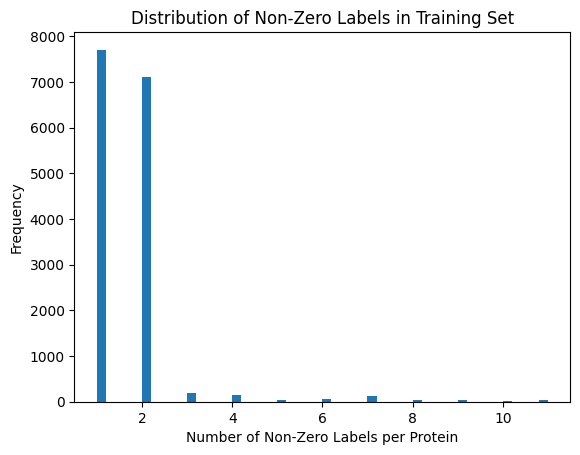

In [34]:
import matplotlib.pyplot as plt

plt.hist(train_labels.numpy().sum(axis=1), bins=50)
plt.title('Distribution of Non-Zero Labels in Training Set')
plt.xlabel('Number of Non-Zero Labels per Protein')
plt.ylabel('Frequency')
plt.show()
